# Fake news classification (RU)


In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)

## EDA

Посмотрим на данные, распределения, баланс классов

In [2]:
train_data = pd.read_csv('dataset/raw/train.tsv', sep='\t')
test_data = pd.read_csv('dataset/raw/test.tsv', sep='\t')


train_data.head()

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


Датасет сбалансирован, это очень хорошо, учитвая то, что наша ключевая метрика - F1

In [3]:
train_data['is_fake'].value_counts()

1    2879
0    2879
Name: is_fake, dtype: int64

<AxesSubplot:>

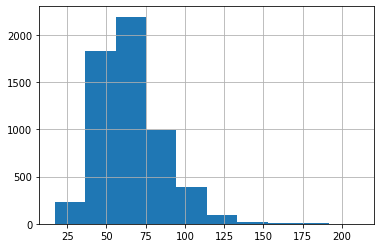

In [4]:
train_data['title'].str.len().hist()

Максимальная длина предложения нужна для некоторых моделей

In [5]:
MAX_SEQ_LENGTH = max(train_data['title'].str.len())
MAX_SEQ_LENGTH

211

## Data preprocessing


In [6]:
from sklearn.model_selection import train_test_split
import nltk

nltk.download('stopwords')

train_data = pd.read_csv('dataset/raw/train.tsv', sep='\t')
test_data = pd.read_csv('dataset/raw/test.tsv', sep='\t')

train_data.head()

[nltk_data] Downloading package stopwords to /home/danya-
[nltk_data]     sakharov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


In [7]:
from preprocess import get_lemmas_from_text

train_data['lemmas'] = get_lemmas_from_text(train_data['title'])
test_data['lemmas'] = get_lemmas_from_text(test_data['title'])
train_data.head()

  0%|          | 0/5758 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,title,is_fake,lemmas
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1,москвич владимир клутин приходить счет вмешате...
1,Агент Кокорина назвал езду по встречке житейск...,0,агент кокорин называть езда встречок житейский...
2,Госдума рассмотрит возможность введения секрет...,1,госдума рассматривать возможность введение сек...
3,ФАС заблокировала поставку скоростных трамваев...,0,фас заблокировать поставка скоростной трамвай ...
4,Против Навального завели дело о недоносительст...,1,против навальный заводить дело недоносительств...


Посмотрим теперь на лемматизированные тексты и самые частотные слова в них 

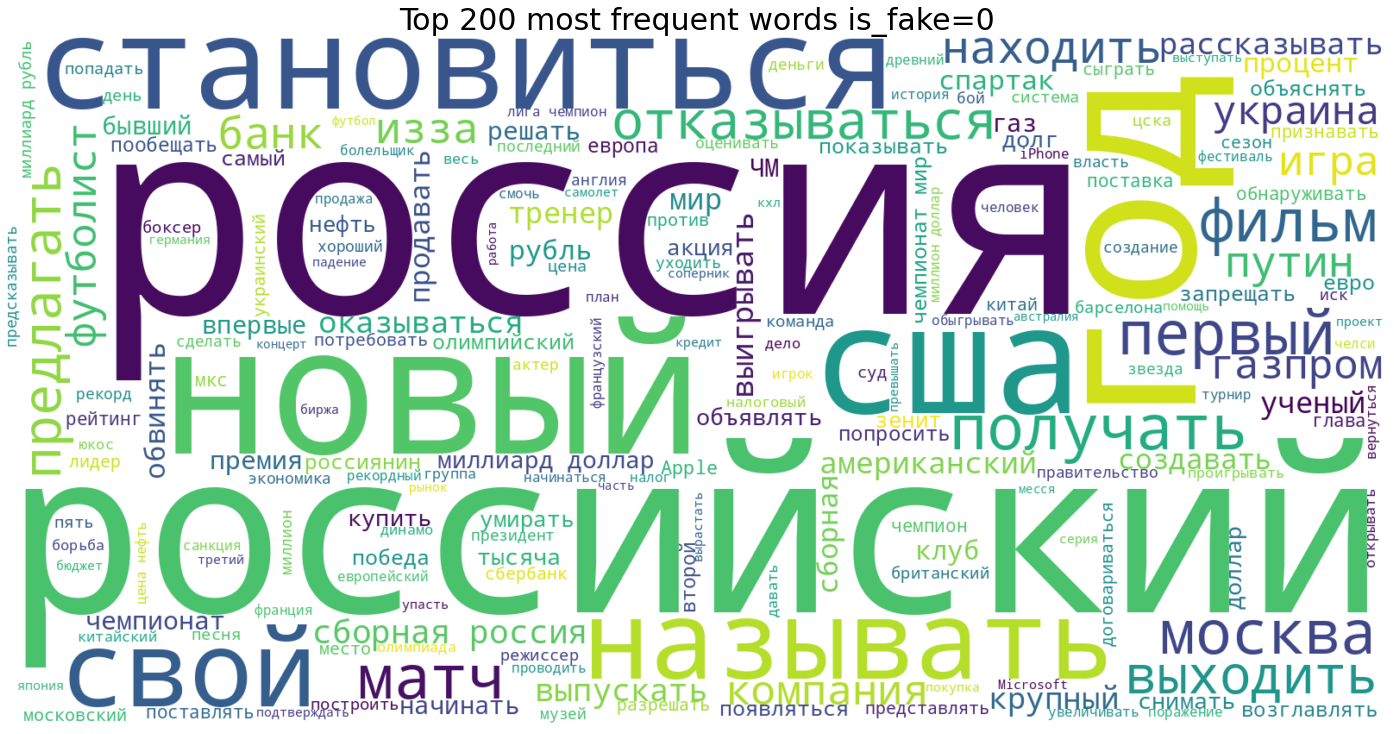

In [8]:
from visualize import get_wordcloud

get_wordcloud(train_data[train_data['is_fake']==0]['lemmas'], title='Top 200 most frequent words is_fake=0')

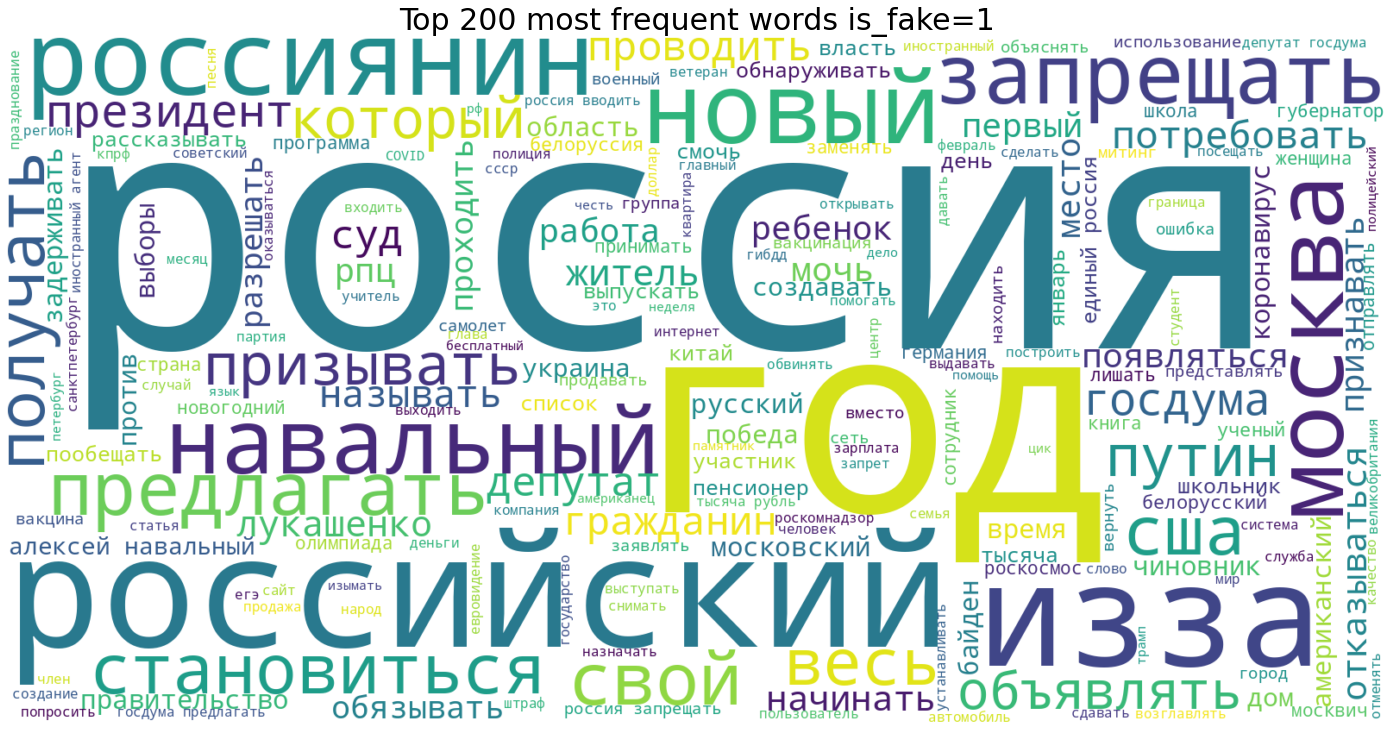

In [9]:
get_wordcloud(train_data[train_data['is_fake']==1]['lemmas'], title='Top 200 most frequent words is_fake=1')

К сожалению, самые частотные слова встречаются как в фейковых, так и настоящих новостях

Разобьем на train/val со стратификацией по is_fake, чтобы поулчить равное количество классов

In [8]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train_data.drop('title',axis=1), test_size=0.2, random_state=42, stratify=train_data['is_fake'])

print("total train examples %s" % len(train))
print("total test examples %s\n" % len(val))
print(train['is_fake'].value_counts())

total train examples 4606
total test examples 1152

1    2303
0    2303
Name: is_fake, dtype: int64


In [9]:
train.to_csv('dataset/preprocessed/train.csv')
val.to_csv('dataset/preprocessed/val.csv')
test_data.to_csv('dataset/preprocessed/test.csv')

## Modelling

### PAC

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import classification_report

tfidf = TfidfVectorizer()
vec_train = tfidf.fit_transform(train['lemmas'])
vec_val = tfidf.transform(val['lemmas'])

pac = PassiveAggressiveClassifier(C = 0.01)

pac.fit(vec_train, train['is_fake'])
val_pred = pac.predict(vec_val)


print(classification_report(val['is_fake'], val_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       576
           1       0.85      0.85      0.85       576

    accuracy                           0.85      1152
   macro avg       0.85      0.85      0.85      1152
weighted avg       0.85      0.85      0.85      1152



Неплохой результат для первой примененной модели, посмотрим на другие

### Fasttext baseline


In [16]:
import fasttext

In [18]:
#Write data to file for fasttext classifier 

with open('fasttext/data.train.txt', 'w+') as outfile:
    for x, y in zip(train['lemmas'], train['is_fake']):
        outfile.write('__label__' + str(y) + ' ' + x + '\n')


with open('fasttext/test.txt', 'w+') as outfile:
    for x, y in zip(val['lemmas'], val['is_fake']):
        outfile.write('__label__' + str(y) + ' ' + x + '\n')

In [31]:
classifier = fasttext.train_supervised('fasttext/data.train.txt', lr=1.0, epoch=25, wordNgrams=3)
    
num, precision, recall = classifier.test('fasttext/test.txt')

print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print('Number of examples:', num)

Read 0M words
Number of words:  9437
Number of labels: 2


Precision: 0.85764
Recall: 0.85764
Number of examples: 1152


Progress: 100.0% words/sec/thread:  543946 lr:  0.000000 avg.loss:  0.023583 ETA:   0h 0m 0s


Тоже неплохой результат, слегка лучше **PAC**

### CatBoost

In [15]:
from catboost import Pool, CatBoostClassifier
import torch

task_type = "GPU" if torch.cuda.is_available() else "CPU"

train_pool = Pool(data=
    train.drop(['is_fake'], axis=1), 
    label=train['is_fake'],
    text_features = ['lemmas']
)

valid_pool = Pool(data=
    val.drop(['is_fake'], axis=1), 
    label=val['is_fake'],
    text_features=['lemmas']
)

model = CatBoostClassifier(verbose=500, use_best_model=True, task_type=task_type)
model.fit(train_pool, eval_set=valid_pool)

In [11]:
pred = model.predict(val.drop(['is_fake'], axis=1))
print(classification_report(val['is_fake'],pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       576
           1       0.86      0.83      0.85       576

    accuracy                           0.85      1152
   macro avg       0.85      0.85      0.85      1152
weighted avg       0.85      0.85      0.85      1152



**Catboost** в среднем показывает аналогичные результаты (из коробки)

Попробуем потюнить параметры с помощью **optuna**

In [11]:
import optuna
from utils import CB_objective
from functools import partial

In [12]:
optuna.logging.set_verbosity(0)
study = optuna.create_study(direction="maximize")
study.optimize(partial(CB_objective, task_type=task_type, train_pool=train_pool,
               valid_pool=valid_pool, val=val), n_trials=50, timeout=600, n_jobs=1)

In [17]:
study.best_params

{'depth': 13,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'learning_rate': 0.08,
 'l2_leaf_reg': 0.2494718345819619}

In [18]:
model = CatBoostClassifier(**study.best_params, use_best_model=True, verbose=500, task_type=task_type)
model.fit(train_pool, eval_set=valid_pool)
pred = model.predict(val.drop(['is_fake'], axis=1))
print(classification_report(val['is_fake'],pred))

0:	learn: 0.6407924	test: 0.6293740	best: 0.6293740 (0)	total: 327ms	remaining: 5m 26s
500:	learn: 0.1293011	test: 0.3517248	best: 0.3423119 (257)	total: 2m 31s	remaining: 2m 30s
999:	learn: 0.0575841	test: 0.3785409	best: 0.3423119 (257)	total: 5m 1s	remaining: 0us
bestTest = 0.3423119121
bestIteration = 257
Shrink model to first 258 iterations.
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       576
           1       0.89      0.85      0.87       576

    accuracy                           0.87      1152
   macro avg       0.87      0.87      0.87      1152
weighted avg       0.87      0.87      0.87      1152



Отличный результат, побили предыдущие модели

### BERT


Попробуем предобученный RuBERT с DeepPavlov

In [12]:
from transformers import AutoTokenizer

TOKENIZER_NAME = "DeepPavlov/rubert-base-cased"
MODEL_NAME = "DeepPavlov/rubert-base-cased"
SAVED_MODEL_NAME = MODEL_NAME.split("/", 1)[1]
BATCH_SIZE = 16

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)

In [13]:
from preprocess import convert_examples_to_inputs
from preprocess import get_data_loader

train_features = convert_examples_to_inputs(
    train['lemmas'], train['is_fake'], MAX_SEQ_LENGTH, tokenizer)
val_features = convert_examples_to_inputs(
    val['leemas'], val['is_fake'], MAX_SEQ_LENGTH, tokenizer)

train_dataloader = get_data_loader(train_features, BATCH_SIZE, shuffle=True)
val_dataloader = get_data_loader(val_features, BATCH_SIZE, shuffle=False)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [18]:
from transformers.models.bert.modeling_bert import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(MODEL_NAME)
out_features = model.bert.encoder.layer[1].output.dense.out_features
model.classifier = torch.nn.Linear(out_features, 2)

model.to(device)

Some weights of the model checkpoint at DeepPavlov/bert-base-bg-cs-pl-ru-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassificat

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [21]:
from transformers.optimization import get_linear_schedule_with_warmup
from torch.optim import AdamW

GRADIENT_ACCUMULATION_STEPS = 1
NUM_TRAIN_EPOCHS = 5
LEARNING_RATE = 1e-5
WARMUP_PROPORTION = 0.1
MAX_GRAD_NORM = 5
OUTPUT_DIR = "trained_models/"
PATIENCE = 4

num_train_steps = int(len(train_dataloader.dataset) /
                      BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
                      
num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

param_optimizer = list(model.named_parameters())

no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(
        nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(
        nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)
loss_fn = torch.nn.CrossEntropyLoss()

In [11]:
import torch
import os
from model import train

loss_history = []
acc_history = []
no_improvement = 0

config = (int(NUM_TRAIN_EPOCHS), GRADIENT_ACCUMULATION_STEPS, MAX_GRAD_NORM, SAVED_MODEL_NAME)
train(device, model, train_dataloader, val_dataloader, loss_fn, optimizer, scheduler, config)

NameError: name 'NUM_TRAIN_EPOCHS' is not defined

In [22]:
from model import val_report

model_state_dict = torch.load(os.path.join(OUTPUT_DIR, SAVED_MODEL_NAME), map_location=lambda storage, loc: storage)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, state_dict=model_state_dict)

dev_correct, dev_predicted = val_report(device, model, train_dataloader, val_dataloader, loss_fn)

Evaluation iteration:   0%|          | 0/234 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/126 [00:00<?, ?it/s]

Training performance: (0.9826296098343132, 0.9826296098343132, 0.9826296098343132, None)
Development performance: (0.8859126984126984, 0.8859126984126984, 0.8859126984126984, None)
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       989
           1       0.89      0.89      0.89      1027

    accuracy                           0.89      2016
   macro avg       0.89      0.89      0.89      2016
weighted avg       0.89      0.89      0.89      2016



In [19]:
incorrect_samples = []
for feature, predict in zip(val_features, list(dev_correct != dev_predicted)):
    if predict:
        print(feature.text, feature.label_id) 
        incorrect_samples.append(feature.text)

ученый ради марс проживать восемь месяц изоляция гавайи 0
москвич пригрозить останавливать работа старый McDonalds россия 0
основной кормилец процент семья сша оказываться женщина 0
бритни спирс обвинять жестокий обращение ребенок 0
искусствовед картина мона лиза изображать мать иван грозный 1
огненный шоколад заинтересовывать российский орган власть 0
центробанк начинать размещать реклама новый купюра 1
медведев потребовать продавать Twitter российский компания 1
камасутра признавать олимпийский вид спорт 1
доллар рухнуть отказ ФНБ американский валюта 1
россия вступать сила мораторий действие довсе 0
борьба безработица правительство отменять социальный пособие 1
экономия кислород мкс катапультировать весь женщина 1
гендиректор белавиа самолет оправдывать 1
лондонский конкурс двойник мистер бин побеждать аутист саратов 1
летний аргентинка забеременеть прививка спутник V 1
прессслужба президент предсказывать серьезный проблема здоровье профессор соловей 1
пол маккартень приглашать свой 

## Test inference (BERT)

In [25]:
from model import evaluate

test_features = convert_examples_to_inputs(test_data['lemmas'], test_data['is_fake'], MAX_SEQ_LENGTH, tokenizer)
test_dataloader = get_data_loader(test_features, BATCH_SIZE, shuffle=False)

_, _, predicted_labels = evaluate(device, model, test_dataloader, loss_fn)

Evaluation iteration:   0%|          | 0/63 [00:00<?, ?it/s]

In [61]:
prediction = pd.DataFrame({'title':test_data['title'], 'is_fake':pd.Series(predicted_labels)})
prediction.to_csv('prediction.csv', sep='\t', index=False)